In [ ]:
import os
os.chdir('d:/future/Index_Future_Prediction')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm
import optuna
import backtrader as bt

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from torch.utils.data import TensorDataset, DataLoader

from utils import *
from modules import *

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

我们先用一个简单方案，直接在backtrader外计算好模型给出的操作建议，然后输入到backtrader

In [645]:
class Patch_TST(nn.Module):
    """Patch Time Series Transformer"""
    def __init__(self, input_size, seq_len, patch_size, stride, num_layer, num_head, d_model, masking_ratio, mask_expand_size, dropout_1, dropout_2, dropout_3):
        super().__init__()
        self.device = 'cuda:0'
        self.input_size = input_size
        self.patch_size = patch_size
        self.stride = stride
        self.masking_ratio = masking_ratio
        self.mask_expand_size = mask_expand_size # 扩展mask的宽度 1 表示向左右各扩展一个patch

        self.num_patch = int(np.floor((seq_len - patch_size) / stride) + 1)

        self.patch = TimeSeriesPatcher(patch_size, stride) # 首先经过patcher分成子序列

        self.projection = PatchProjection(input_size, patch_size, d_model = d_model, dropout = dropout_1)

        self.encoder = MultiLayerEncoder(dim_feature = d_model, dim_sequence = self.num_patch, num_enc_layer = num_layer, num_head = num_head, num_ffn_hidden = d_model*2, dropout = dropout_2)

        self.reconstruction = nn.Linear(d_model, input_size * patch_size)
        
        self.output = nn.Sequential(
            nn.Flatten(start_dim = -2),
            # nn.Linear(self.num_patch * d_model, self.num_patch * d_model),
            nn.Dropout(dropout_3),
            HybridDecoder(dim_state = self.num_patch * d_model, init_prob = [0.0,0.5,0.0])
        )
    
    def self_supervised(self, x):
        """
        自监督预训练
        如果不允许patch重叠，正好被patch隔断的形态无法学习到。
        允许patch重叠，则模型预训练的时候可以从前后patch偷看到信息。
        需要用双重mask
        target mask 是真正需要重建的patch
        input mask 是target mask的扩展，根据系数向两侧扩展掩蔽范围。例如假如patch允许重叠50%，则向前后各多屏蔽一个patch就可以完全屏蔽掉信息。
        """
        device = x.device
        batch_size = x.shape[0]


        noise = torch.rand(size=(batch_size, self.num_patch), device=device)
        target_mask = noise < self.masking_ratio
        
        # 防止出现所有 patch 都没被 mask 的情况，至少 mask 一个随机选择一个 patch 进行 mask
        if not target_mask.any(dim=1).all():
            for i in range(batch_size):
                if not target_mask[i].any():
                    fallback_idx = torch.randint(0, self.num_patch, (1,)).item()
                    target_mask[i, fallback_idx] = True

        target_mask_float = target_mask.float().unsqueeze(1)
        kernel_size = 2 * self.mask_expand_size + 1
        kernel = torch.ones(1, 1, kernel_size, device=device)
        padding = self.mask_expand_size
        expanded_mask_float = F.conv1d(target_mask_float, kernel, padding=padding)
        input_mask = (expanded_mask_float > 0).squeeze(1)


        x_patched = self.patch(x)
        reshape_mask = input_mask.unsqueeze(-1)
        x_masked = torch.where(reshape_mask, 0.0, x_patched)
        x_projected = self.projection(x_masked)
        x_encodered = self.encoder(x_projected)
        
        x_pre_reconstruction = x_encodered[target_mask] # 仅关注target mask
        x_reconstructed = self.reconstruction(x_pre_reconstruction)
        x_target = x_patched[target_mask] # 仅关注target mask

        return x_reconstructed, x_target
    
    def forward(self, x):
        """前向传播输出"""
        x_patched = self.patch(x)
        x_projected = self.projection(x_patched)
        x_encodered = self.encoder(x_projected)
        output = self.output(x_encodered)
        return output
        

In [ ]:
class TargetPositionStrategy(bt.Strategy):
    """
    基于回望期信号确定目标仓位，并进行调整。
    同时记录每日的总资产价值用于后续绘图。
    """
    params = (
        ('lookback', 5),
    )

    def __init__(self):
        self.log_dates = []
        self.log_values = []

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} - {txt}')
        
    def next(self):
        self.log_dates.append(self.data.datetime.date(0))
        self.log_values.append(self.broker.getvalue())

        for d in self.datas:
            if len(d) < self.p.lookback:
                continue
            signals = d.openinterest.get(size=self.p.lookback)
            target_position = int(sum(signals))
            current_position = self.getposition(d).size

            if target_position != current_position:
                self.order_target_size(data=d, target=target_position)
    
    def stop(self):

        for d in self.datas:
            if self.getposition(d).size != 0:
                self.order_target_size(data=d, target=0)


In [647]:
seq_len = 160
patch_size = 8
num_layer = 5
num_head = 8
d_model = 256
stride = 4 # patch_size // 2  奇数再(+1)
masking_ratio = 0.2
mask_expand_size = 1



seq_len = 200
patch_size = 10
num_layer = 5
num_head = 4
d_model = 32
stride = 4
masking_ratio = 0.2
mask_expand_size = 1





model = Patch_TST(input_size = 10,
                    seq_len = seq_len,
                    patch_size = patch_size,
                    stride = stride,
                    num_layer = num_layer, 
                    num_head = num_head,
                    d_model = d_model,
                    masking_ratio = masking_ratio,
                    mask_expand_size = mask_expand_size,
                    dropout_1 = 0,
                    dropout_2 = 0,
                    dropout_3 = 0,
                    ).to('cuda:0')
model.eval()

Patch_TST(
  (patch): TimeSeriesPatcher()
  (projection): PatchProjection(
    (project): Linear(in_features=100, out_features=32, bias=True)
    (pe): PositionalEncoding(
      (dropout): Dropout(p=0, inplace=False)
    )
  )
  (encoder): MultiLayerEncoder(
    (layers): ModuleList(
      (0-4): 5 x EncoderBlock(
        (attn): MultiHeadAttention(
          (wq): Linear(in_features=32, out_features=32, bias=True)
          (wk): Linear(in_features=32, out_features=32, bias=True)
          (wv): Linear(in_features=32, out_features=32, bias=True)
          (fc_out): Linear(in_features=32, out_features=32, bias=True)
        )
        (addnorm1): AddNorm(
          (dropout): Dropout(p=0, inplace=False)
          (ln): LayerNorm((48, 32), eps=1e-05, elementwise_affine=True)
        )
        (ffn): PositionWiseFFN(
          (dense1): Linear(in_features=32, out_features=64, bias=True)
          (relu): GELU(approximate='none')
          (dense2): Linear(in_features=64, out_features=32, 

In [ ]:


feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
label_columns = ['label_return','down_prob','middle_prob','up_prob']

assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]
# assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX']
assets_list = ['JM.DCE','RB.SHF','HC.SHF', 'I.DCE',]

model.load_state_dict(torch.load('params/supervised_1.params'))
model.eval()

Patch_TST(
  (patch): TimeSeriesPatcher()
  (projection): PatchProjection(
    (project): Linear(in_features=100, out_features=32, bias=True)
    (pe): PositionalEncoding(
      (dropout): Dropout(p=0, inplace=False)
    )
  )
  (encoder): MultiLayerEncoder(
    (layers): ModuleList(
      (0-4): 5 x EncoderBlock(
        (attn): MultiHeadAttention(
          (wq): Linear(in_features=32, out_features=32, bias=True)
          (wk): Linear(in_features=32, out_features=32, bias=True)
          (wv): Linear(in_features=32, out_features=32, bias=True)
          (fc_out): Linear(in_features=32, out_features=32, bias=True)
        )
        (addnorm1): AddNorm(
          (dropout): Dropout(p=0, inplace=False)
          (ln): LayerNorm((48, 32), eps=1e-05, elementwise_affine=True)
        )
        (ffn): PositionWiseFFN(
          (dense1): Linear(in_features=32, out_features=64, bias=True)
          (relu): GELU(approximate='none')
          (dense2): Linear(in_features=64, out_features=32, 

In [649]:
start_date = datetime(2021, 9, 1)
end_date = datetime(2023, 9, 1)
cerebro = bt.Cerebro()


for asset_code in assets_list:
    data = pd.read_csv(f'data/{asset_code}.csv')
    data['trade_date'] = pd.to_datetime(data['trade_date'], format = '%Y%m%d')
    data.index = data['trade_date']


    input = torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0')
    input = input.unfold(dimension = 0, size = seq_len, step = 1).transpose(1,2)
    output = model(input).detach().cpu().numpy()
    prob_prediction = np.argmax(output[:,1:], axis = 1) - 1  # 转换为 -1, 0, +1 的方向表示


    days = data['trade_date'][seq_len-1:]
    position = pd.Series(index = days, data = prob_prediction, name = 'openinterest') # 为了方便，我们直接覆盖掉没使用的open interest
    data = data.join(position, how='left')

    data['volume'] = data['vol']
    data = data[['open', 'high', 'low', 'close', 'volume', 'openinterest']][160-1:].copy()
    feed_data = bt.feeds.PandasData(dataname=data, fromdate=start_date, todate=end_date, name = asset_code)  # 加载数据
    cerebro.adddata(feed_data)


cerebro.broker.setcash(70000.0) # 5份IH 5份IF 5份IC 最大理论单边持仓约7w
cerebro.broker.setcommission(commission=0.0001)
cerebro.addstrategy(TargetPositionStrategy)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strategy_instance = results[0]

sharpe_analysis = strategy_instance.analyzers.sharpe.get_analysis()
returns_analysis = strategy_instance.analyzers.returns.get_analysis()
drawdown_analysis = strategy_instance.analyzers.drawdown.get_analysis()
trades_analysis = strategy_instance.analyzers.trades.get_analysis()

print(f"Sharpe Ratio: {sharpe_analysis.get('sharperatio', 'N/A'):.4f}")
print(f"Annualized Return: {returns_analysis.get('rnorm100', 'N/A'):.2f}%")
print(f"Max Drawdown: {drawdown_analysis.max.get('drawdown', 'N/A'):.2f}%")
if trades_analysis.total.total > 0:
    print(f"Total Trades: {trades_analysis.total.total}")
    print(f"Win Rate: {(trades_analysis.won.total / trades_analysis.total.total) * 100:.2f}%")
    print(f"Average PnL per Trade: {trades_analysis.pnl.net.average:.2f}")

Final Portfolio Value: 84209.31
Sharpe Ratio: 0.4144
Annualized Return: 10.06%
Max Drawdown: 9.33%
Total Trades: 110
Win Rate: 46.36%
Average PnL per Trade: 140.44


In [650]:
start_date = datetime(2023, 9, 1)
end_date = datetime(2024, 9, 1)
cerebro = bt.Cerebro()


for asset_code in assets_list:

    data = pd.read_csv(f'data/{asset_code}.csv')
    data['trade_date'] = pd.to_datetime(data['trade_date'], format = '%Y%m%d')
    data.index = data['trade_date']


    input = torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0')
    input = input.unfold(dimension = 0, size = seq_len, step = 1).transpose(1,2)
    output = model(input).detach().cpu().numpy()
    prob_prediction = np.argmax(output[:,1:], axis = 1) - 1  # 转换为 -1, 0, +1 的方向表示


    days = data['trade_date'][seq_len-1:]
    position = pd.Series(index = days, data = prob_prediction, name = 'openinterest') # 为了方便，我们直接覆盖掉没使用的open interest
    data = data.join(position, how='left')

    data['volume'] = data['vol']
    data = data[['open', 'high', 'low', 'close', 'volume', 'openinterest']][160-1:].copy()
    feed_data = bt.feeds.PandasData(dataname=data, fromdate=start_date, todate=end_date, name = asset_code)  # 加载数据
    cerebro.adddata(feed_data)


cerebro.broker.setcash(70000.0) # 5份IH 5份IF 5份IC 最大理论单边持仓约7w
cerebro.broker.setcommission(commission=0.0001)
cerebro.addstrategy(TargetPositionStrategy)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strategy_instance = results[0]

sharpe_analysis = strategy_instance.analyzers.sharpe.get_analysis()
returns_analysis = strategy_instance.analyzers.returns.get_analysis()
drawdown_analysis = strategy_instance.analyzers.drawdown.get_analysis()
trades_analysis = strategy_instance.analyzers.trades.get_analysis()

print(f"Sharpe Ratio: {sharpe_analysis.get('sharperatio', 'N/A'):.4f}")
print(f"Annualized Return: {returns_analysis.get('rnorm100', 'N/A'):.2f}%")
print(f"Max Drawdown: {drawdown_analysis.max.get('drawdown', 'N/A'):.2f}%")
if trades_analysis.total.total > 0:
    print(f"Total Trades: {trades_analysis.total.total}")
    print(f"Win Rate: {(trades_analysis.won.total / trades_analysis.total.total) * 100:.2f}%")
    print(f"Average PnL per Trade: {trades_analysis.pnl.net.average:.2f}")

Final Portfolio Value: 75018.83
Sharpe Ratio: 47.6911
Annualized Return: 7.48%
Max Drawdown: 1.83%
Total Trades: 85
Win Rate: 50.59%
Average PnL per Trade: 57.35


In [651]:
start_date = datetime(2024, 9, 1)
end_date = datetime(2025, 9, 1)
cerebro = bt.Cerebro()

for asset_code in assets_list:

    data = pd.read_csv(f'data/{asset_code}.csv')
    data['trade_date'] = pd.to_datetime(data['trade_date'], format = '%Y%m%d')
    data.index = data['trade_date']


    input = torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0')
    input = input.unfold(dimension = 0, size = seq_len, step = 1).transpose(1,2)
    output = model(input).detach().cpu().numpy()
    prob_prediction = np.argmax(output[:,1:], axis = 1) - 1  # 转换为 -1, 0, +1 的方向表示


    days = data['trade_date'][seq_len-1:]
    position = pd.Series(index = days, data = prob_prediction, name = 'openinterest') # 为了方便，我们直接覆盖掉没使用的open interest
    data = data.join(position, how='left')

    data['volume'] = data['vol']
    data = data[['open', 'high', 'low', 'close', 'volume', 'openinterest']][160-1:].copy()
    feed_data = bt.feeds.PandasData(dataname=data, fromdate=start_date, todate=end_date, name = asset_code)  # 加载数据
    cerebro.adddata(feed_data)


cerebro.broker.setcash(70000.0) # 5份IH 5份IF 5份IC 最大理论单边持仓约7w
cerebro.broker.setcommission(commission=0.0001)
cerebro.addstrategy(TargetPositionStrategy)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strategy_instance = results[0]

sharpe_analysis = strategy_instance.analyzers.sharpe.get_analysis()
returns_analysis = strategy_instance.analyzers.returns.get_analysis()
drawdown_analysis = strategy_instance.analyzers.drawdown.get_analysis()
trades_analysis = strategy_instance.analyzers.trades.get_analysis()

print(f"Sharpe Ratio: {sharpe_analysis.get('sharperatio', 'N/A'):.4f}")
print(f"Annualized Return: {returns_analysis.get('rnorm100', 'N/A'):.2f}%")
print(f"Max Drawdown: {drawdown_analysis.max.get('drawdown', 'N/A'):.2f}%")
if trades_analysis.total.total > 0:
    print(f"Total Trades: {trades_analysis.total.total}")
    print(f"Win Rate: {(trades_analysis.won.total / trades_analysis.total.total) * 100:.2f}%")
    print(f"Average PnL per Trade: {trades_analysis.pnl.net.average:.2f}")

Final Portfolio Value: 73357.92
Sharpe Ratio: 0.5284
Annualized Return: 5.00%
Max Drawdown: 3.97%
Total Trades: 39
Win Rate: 53.85%
Average PnL per Trade: 113.62


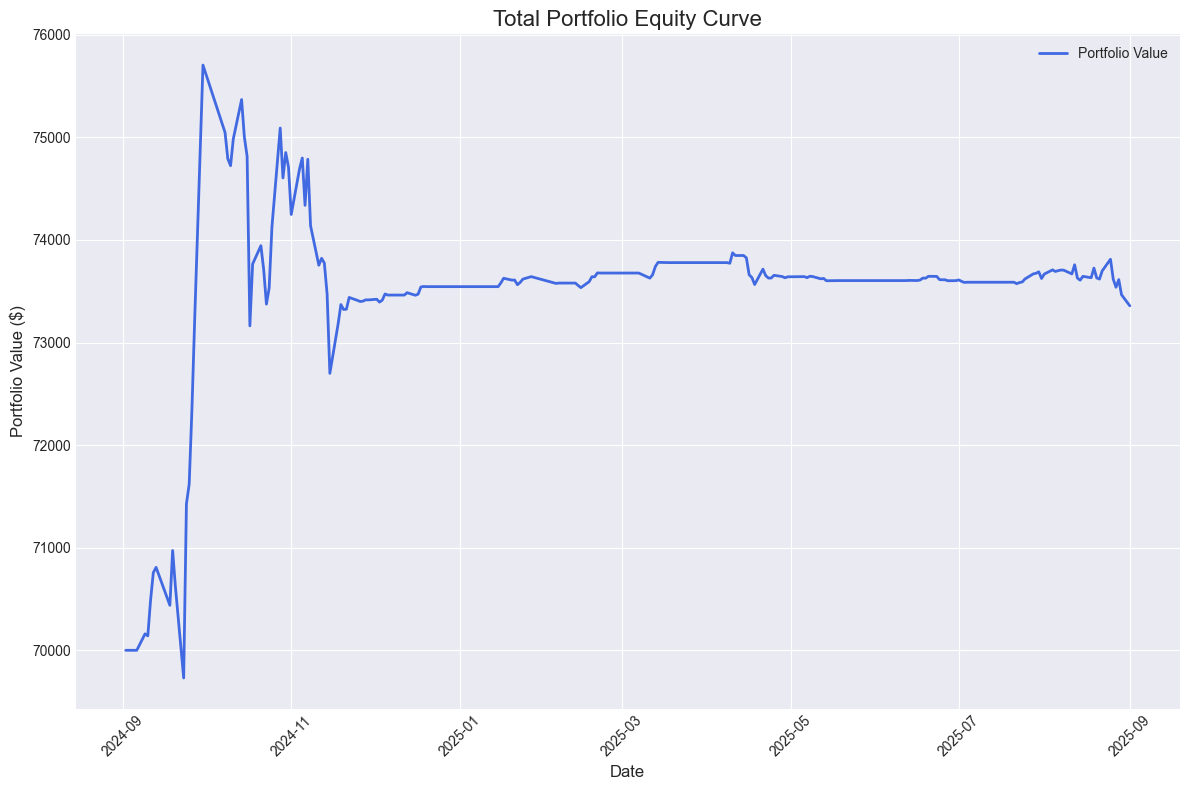

In [652]:
import matplotlib.dates as mdates

# 从策略实例中获取记录的数据
strategy_instance = results[0]
log_dates = strategy_instance.log_dates
log_values = strategy_instance.log_values

# 转换为 Pandas Series，便于操作
equity_curve = pd.Series(log_values, index=pd.to_datetime(log_dates))

# 创建收益率曲线
returns = equity_curve.pct_change().fillna(0)
cumulative_returns = (1 + returns).cumprod()
    
# 绘图
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(equity_curve.index, equity_curve.values, label='Portfolio Value', color='royalblue', linewidth=2)
    
# 格式化图表
ax.set_title('Total Portfolio Equity Curve', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Portfolio Value ($)', fontsize=12)
ax.legend()
ax.grid(True)
    
# 格式化x轴日期显示
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

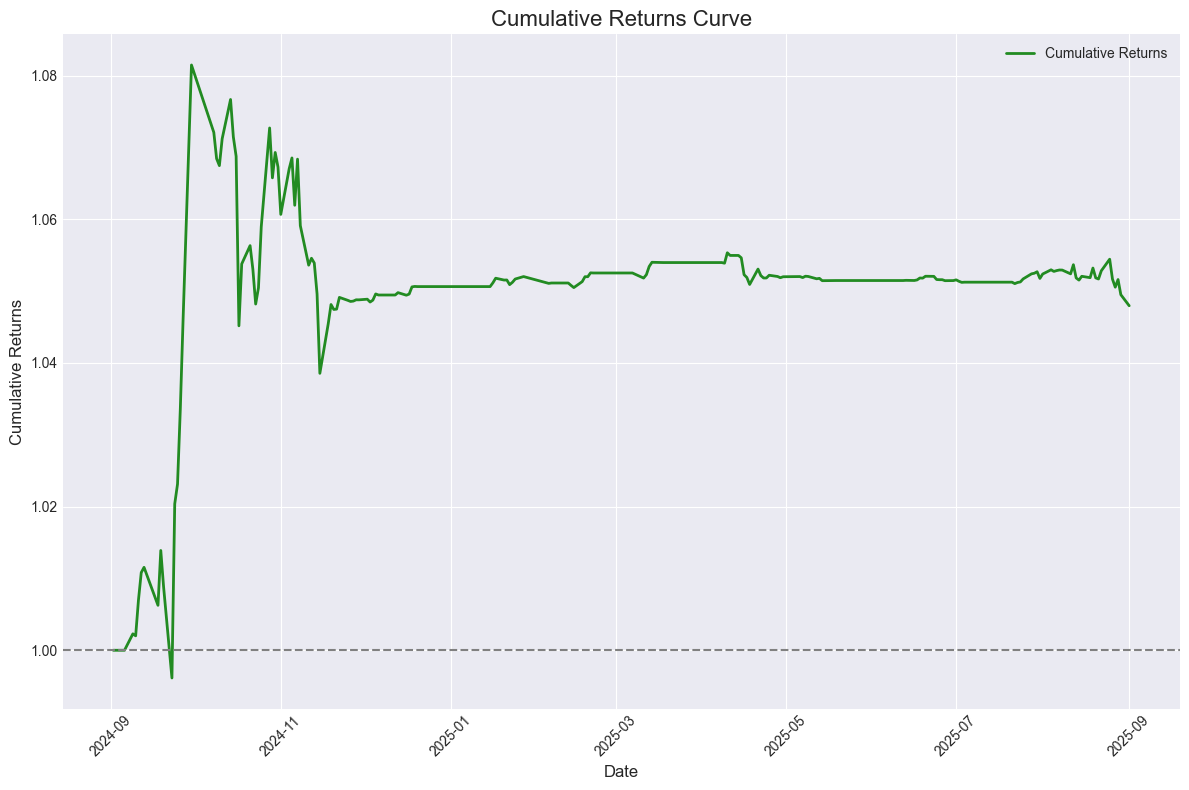

In [653]:
# (可选) 绘制累计收益率曲线
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(cumulative_returns.index, cumulative_returns.values, label='Cumulative Returns', color='forestgreen', linewidth=2)
ax.set_title('Cumulative Returns Curve', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Returns', fontsize=12)
ax.legend()
ax.grid(True)
ax.axhline(1.0, color='gray', linestyle='--') # 添加基准线
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()